In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from modules import *
from data import *
from utils import *

In [2]:
# ...existing code...
import ast
from types import SimpleNamespace

def _parse_value(s: str):
    s = s.strip()
    if s.lower() == "none":
        return None
    if s.lower() == "true":
        return True
    if s.lower() == "false":
        return False
    # Lists: try literal_eval; if it fails, handle space-separated lists like [0 1 2]
    if s.startswith("[") and s.endswith("]"):
        inner = s[1:-1].strip()
        if inner == "":
            return []
        try:
            return ast.literal_eval(s)
        except Exception:
            tokens = inner.split()
            def _tok(t):
                if t.startswith(("'", '"')) and t.endswith(("'", '"')):
                    return t[1:-1]
                try:
                    return float(t) if "." in t else int(t)
                except ValueError:
                    return t
            return [_tok(t) for t in tokens]
    # Numbers or quoted strings
    try:
        return float(s) if "." in s else int(s)
    except ValueError:
        try:
            return ast.literal_eval(s)
        except Exception:
            return s

def read_config(path: str) -> SimpleNamespace:
    d = {}
    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#") or ":" not in line:
                continue
            k, v = line.split(":", 1)
            d[k.strip()] = _parse_value(v.strip())
    return SimpleNamespace(**d)

folder = "/r/scratch/users/mschillinger/code/cordexbench/enscale/results/Emulator_hist_future/ALPS/no-orog/coarse/var-tasmax/hd-100_num-lay-6_norm-out-normalise_per_period_norm-in-normalise_per_period_nd-100_PAST-FUTURE-SPLIT"
cfg_path =  folder + "/config.txt"
args = read_config(cfg_path)

# quick sanity-check
print("domain:", args.domain)
print("variables:", args.variables)
print("run_indices:", args.run_indices)


domain: ALPS
variables: ['tasmax']
run_indices: [0, 1, 2, 3, 4, 5, 6, 7]


In [186]:
train_loader, test_loader_in = get_data_cordexbench(
        domain=args.domain,
        training_experiment=args.training_experiment,
        shuffle=True, batch_size=512,
        tr_te_split = args.tr_te_split, test_size=1-args.tr_te_split_ratio,
        server=args.server,
        variables=args.variables, variables_lr=args.variables_lr,
        mode = "train",
        norm_input=args.norm_method_input, norm_output=args.norm_method_output,
        sqrt_transform_in=args.sqrt_transform_in, sqrt_transform_out=args.sqrt_transform_out,
        kernel_size=args.kernel_size_lr, kernel_size_hr=args.kernel_size_hr, return_timepair=False,
        clip_quantile=None, 
        logit=args.logit_transform,
        normal=args.normal_transform,
        include_year=False,
        only_winter=False, stride_lr=None, padding_lr=None,
        filter_outliers=False, precip_zeros="random",)

device = "cpu"
x_tr_eval, xc_tr_eval, y_tr_eval = next(iter(train_loader))
x_tr_eval, xc_tr_eval, y_tr_eval = x_tr_eval[:args.n_visual].to(device), xc_tr_eval[:args.n_visual].to(device), y_tr_eval[:args.n_visual].to(device)
x_te_eval, xc_te_eval, y_te_eval = next(iter(test_loader_in))
x_te_eval, xc_te_eval, y_te_eval = x_te_eval[:args.n_visual].to(device), xc_te_eval[:args.n_visual].to(device), y_te_eval[:args.n_visual].to(device)


/r/scratch/users/mschillinger/data/cordexbench/ALPS/ALPS_domain/train/Emulator_hist_future/target/pr_tasmax_CNRM-CM5_1961-1980_2080-2099.nc
y data: torch.Size([14610, 1, 16384])
x data: torch.Size([14610, 3845])
z (x coarsened) data: torch.Size([14610, 1, 64])


In [187]:
if args.variables_lr == ["all"]:
    input_dims_for_preproc = np.array([256 for k in range(15)] +
                [5])
else:
    input_dims_for_preproc = np.array([256 for k in range(len(args.variables_lr))] +
                [5])

In [188]:
in_dim = x_tr_eval.shape[1]
out_dim = y_tr_eval.shape[-1]
interm_dim = xc_tr_eval.shape[-1] * len(args.variables)
if args.method == "eng_temporal":
    in_dim = in_dim + interm_dim
val_dim = None

model = StoUNet(in_dim, interm_dim, args.num_layer, args.hidden_dim, args.noise_dim,
                        add_bn=args.bn, out_act=args.out_act, resblock=args.mlp, noise_std=args.noise_std,
                        preproc_layer=args.preproc_layer,
                        input_dims_for_preproc=input_dims_for_preproc,
                        preproc_dim=args.preproc_dim, layer_shrinkage=args.layer_shrinkage,
                        bottleneck_dim=args.bottleneck_dim).to(device)

In [189]:
model.load_state_dict(torch.load(folder + "/model_599.pt", map_location=device))

<All keys matched successfully>

### Option 1: naive unnormalise

In [190]:
# Case 1: apply to all data (test + train); not suffled; normalised as in args

test_loader_in, _ = get_data_cordexbench(
            domain=args.domain,
            training_experiment=args.training_experiment,
            shuffle=False, batch_size=512,
            tr_te_split = "random", test_size=0.0,
            server=args.server,
            variables=args.variables, variables_lr=args.variables_lr,
            mode = "train",
            norm_input=args.norm_method_input, norm_output=args.norm_method_output,
            sqrt_transform_in=args.sqrt_transform_in, sqrt_transform_out=args.sqrt_transform_out,
            kernel_size=args.kernel_size_lr, kernel_size_hr=1, return_timepair=False,
            clip_quantile=None, 
            logit=args.logit_transform,
            normal=args.normal_transform,
            include_year=False,
            only_winter=False, stride_lr=None, padding_lr=None,
            filter_outliers=False, precip_zeros="random",)



/r/scratch/users/mschillinger/data/cordexbench/ALPS/ALPS_domain/train/Emulator_hist_future/target/pr_tasmax_CNRM-CM5_1961-1980_2080-2099.nc
y data: torch.Size([14610, 1, 16384])
x data: torch.Size([14610, 3845])
z (x coarsened) data: torch.Size([14610, 1, 64])


In [191]:
args.norm_method_input, args.norm_method_output

('normalise_per_period', 'normalise_per_period')

In [192]:
model.eval()
preds = []
trues = []
with torch.no_grad():
    for batch in test_loader_in:
        x, xc, y = batch
        x = x.to(device)
        xc = xc.to(device) if xc is not None else None
        y = y.to(device)

        y_hat = model.sample(x.view(x.shape[0], -1), sample_size=10)

        preds.append(y_hat.cpu())
        trues.append(xc.cpu())

samples_norm = torch.cat(preds, dim=0).unsqueeze(1)
trues_tensor = torch.cat(trues, dim=0)

In [193]:
samples_norm.shape

torch.Size([14610, 1, 64, 10])

In [194]:
trues_tensor.shape

torch.Size([14610, 1, 64])

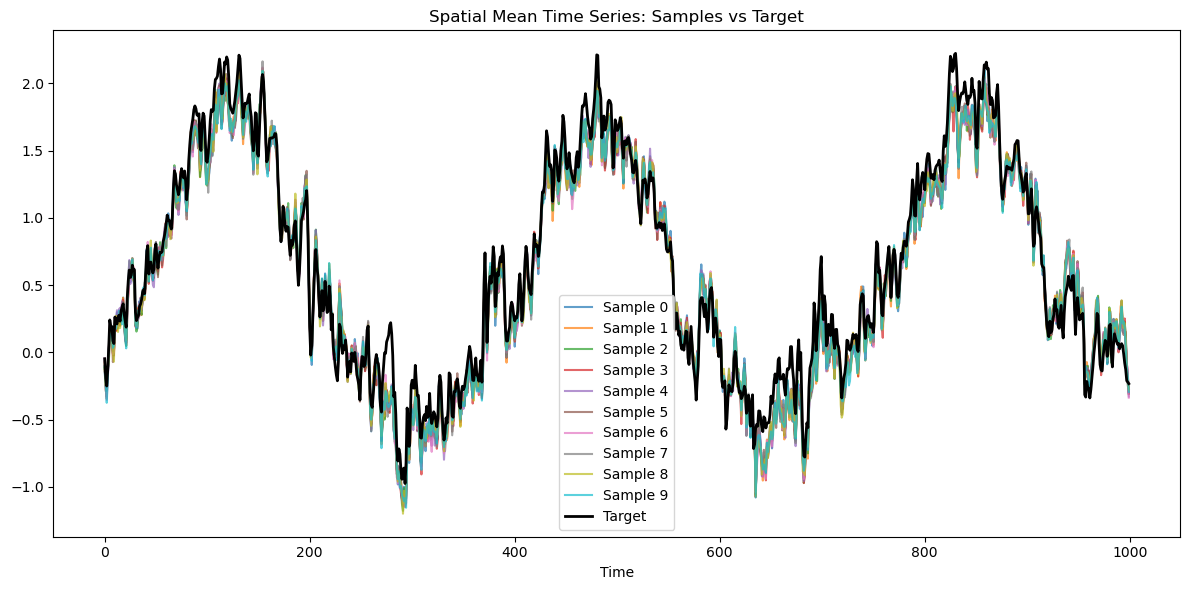

In [195]:
# Calculate spatial mean across y and x dimensions for samples and target
samples = samples_norm

samples_mean = samples.mean(dim=(1, 2)) if hasattr(samples, 'mean') else samples[:, :, :, :, 0].cpu().numpy().reshape(samples.shape[0], samples.shape[1], -1).mean(axis=2)
target_mean = trues_tensor.mean(dim=(1,2))

# Convert to numpy if needed
if hasattr(samples_mean, 'numpy'):
    samples_mean = samples_mean.numpy()
else:
    samples_mean = samples_mean.cpu().numpy() if hasattr(samples_mean, 'cpu') else samples_mean

# Plot time series
plt.figure(figsize=(12, 6))
for i in range(samples.shape[-1]):
    plt.plot(samples_mean[-1000:, ...,i], label=f'Sample {i}', alpha=0.7)
plt.plot(target_mean[-1000:], label='Target', linewidth=2, color='black')
plt.xlabel('Time')
plt.title('Spatial Mean Time Series: Samples vs Target')
plt.legend()
plt.tight_layout()
plt.show()

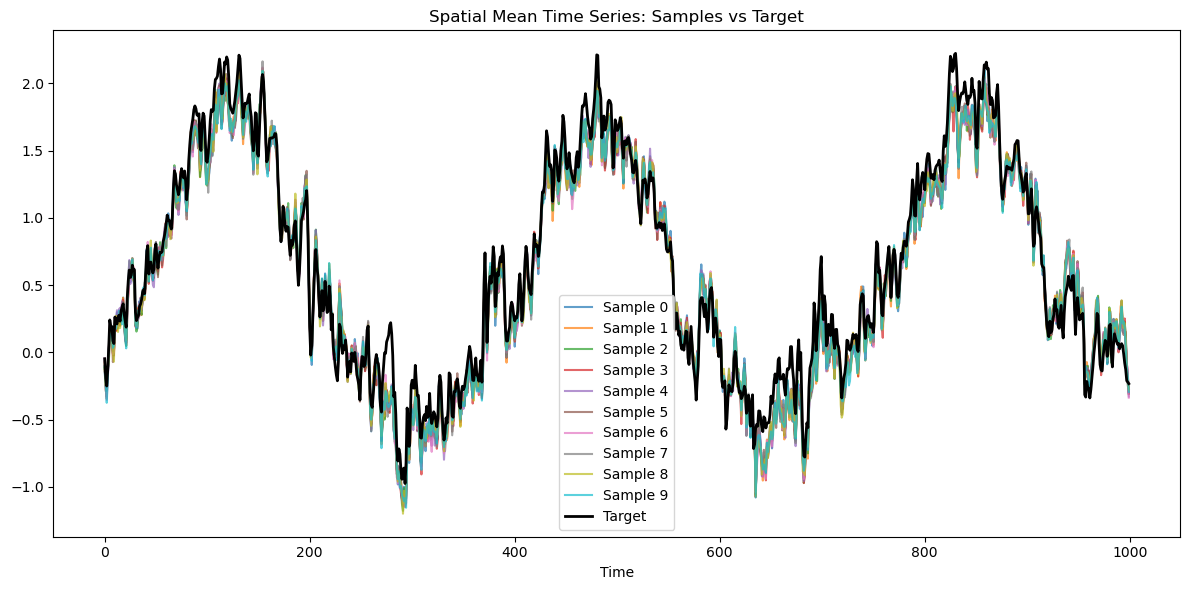

In [196]:
# Calculate spatial mean across y and x dimensions for samples and target
samples = samples_norm

samples_mean = samples.mean(dim=(1, 2)) if hasattr(samples, 'mean') else samples[:, :, :, :, 0].cpu().numpy().reshape(samples.shape[0], samples.shape[1], -1).mean(axis=2)
target_mean = trues_tensor.mean(dim=(1,2))

# Convert to numpy if needed
if hasattr(samples_mean, 'numpy'):
    samples_mean = samples_mean.numpy()
else:
    samples_mean = samples_mean.cpu().numpy() if hasattr(samples_mean, 'cpu') else samples_mean

# Plot time series
plt.figure(figsize=(12, 6))
for i in range(samples.shape[-1]):
    plt.plot(samples_mean[-1000:, ...,i], label=f'Sample {i}', alpha=0.7)
plt.plot(target_mean[-1000:], label='Target', linewidth=2, color='black')
plt.xlabel('Time')
plt.title('Spatial Mean Time Series: Samples vs Target')
plt.legend()
plt.tight_layout()
plt.show()

In [197]:
name = "past"
root="/r/scratch/users/mschillinger/data/cordexbench"

domain=args.domain
training_experiment=args.training_experiment
gcm_name="CNRM-CM5"
if training_experiment == 'ESD_pseudo_reality':
    period_training = '1961-1980'
elif training_experiment == 'Emulator_hist_future':
    period_training = '1961-1980_2080-2099'
data_type=args.variables[0]
name_str = ""
ns_path = os.path.join(root, domain, "norm_stats",
                        f"hr_norm_stats_full-data_{name}_{training_experiment}_{data_type}_{gcm_name}_{period_training}{name_str}.pt")
norm_stats = torch.load(ns_path)

In [198]:
samples_raw = []
samples_counterfact_raw = []
batch_size_unnorm = 10000
n_batches = np.ceil(samples_norm.shape[0] / batch_size_unnorm)
for i in range(int(n_batches)):
    gen = samples_norm[i * batch_size_unnorm: (i+1) * batch_size_unnorm]
    
    gen_raw_allvars_list = []
    for i in range(len(args.variables)):
        gen_raw_var_list = []
        
        for j in range(gen.shape[-1]):
            gen_raw = unnormalise(gen[:, i, :, j], mode="hr_avg", data_type=args.variables[i], sqrt_transform=args.sqrt_transform_out, 
                                norm_method=args.norm_method_output, norm_stats=norm_stats)
            gen_raw_var_list.append(gen_raw)
            
        gen_raw_var = torch.stack(gen_raw_var_list, dim=-1)
        gen_raw_allvars_list.append(gen_raw_var)
        
    gen_raw_allvars = torch.stack(gen_raw_allvars_list, dim=1)
    
    # samples.append(gen_raw_allvars)
    samples_raw.append(gen_raw_allvars)
samples_raw = torch.cat(samples_raw, dim=0)

In [199]:
samples_raw.shape

torch.Size([14610, 1, 8, 8, 10])

In [200]:
DATA_PATH = "/r/scratch/users/mschillinger/data/cordexbench/"
folder = "ALPS/ALPS_domain/train"
training_experiment = "Emulator_hist_future"
gcm_name = "CNRM-CM5"
period_training = "1961-1980_2080-2099"
hr_path = f'{DATA_PATH}/{folder}/{training_experiment}/target/pr_tasmax_{gcm_name}_{period_training}.nc'
hr_path

'/r/scratch/users/mschillinger/data/cordexbench//ALPS/ALPS_domain/train/Emulator_hist_future/target/pr_tasmax_CNRM-CM5_1961-1980_2080-2099.nc'

In [201]:
import xarray as xr
target = xr.open_dataset(hr_path)

In [202]:
import torch
import torch.nn.functional as F

# Pooling params (match data.py)
k = args.kernel_size_lr
stride = args.stride_lr if args.stride_lr is not None else k
padding = args.padding_lr if args.padding_lr is not None else 0

vars_hr = args.variables if isinstance(args.variables, (list, tuple)) else [args.variables]
coarse_list = []
for v in vars_hr:
    t = torch.from_numpy(target[v].values).float()   # (time, lat, lon)
    t = torch.flip(t, [1])                           # flip N–S to match training
    n, h, w = t.shape
    pooled = F.avg_pool2d(t.view(n, 1, h, w), kernel_size=k, stride=stride, padding=padding)
    coarse_list.append(pooled.view(n, -1))           # flatten spatial grid

# (time, n_vars, coarse_spatial)
target_coarse_raw = torch.stack(coarse_list, dim=1)
print("coarse target shape:", target_coarse_raw.shape)

coarse target shape: torch.Size([14610, 1, 64])


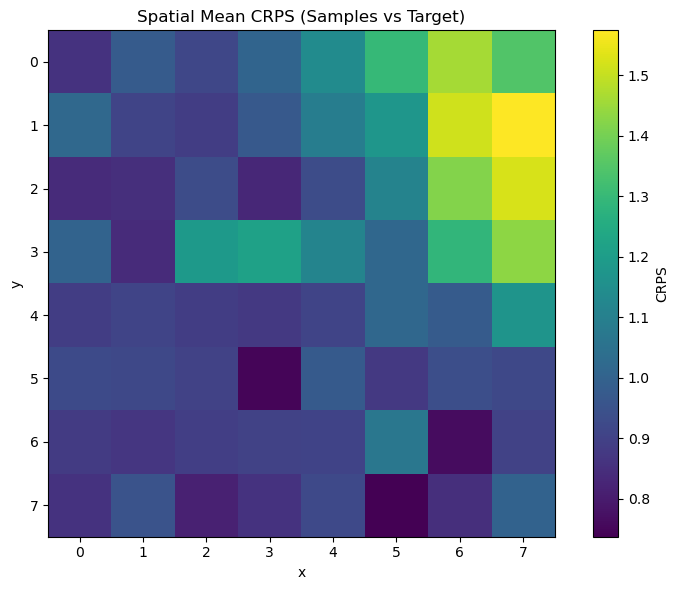

Spatial mean CRPS: 1.0109271


In [203]:
from properscoring import crps_ensemble
samples_np = samples_raw.squeeze(1).numpy()

mid = samples_np.shape[0] // 2
# Get samples: (time, ensemble, y, x)
samples_np_subset = samples_np[mid:]  # (time, y, x, ensemble)
target_np = target_coarse_raw.view(target_coarse_raw.shape[0], 8, 8).numpy()
target_np_subset = target_np[mid:] # (time, y, x)

# Compute CRPS for each grid point and time
crps_map = crps_ensemble(target_np_subset, samples_np_subset)  # shape: (time, y, x)

# Average over time to get spatial CRPS map
crps_spatial = crps_map.mean(axis=0)  # shape: (y, x)

# Plot CRPS map
plt.figure(figsize=(8, 6))
plt.imshow(crps_spatial, cmap='viridis')
plt.colorbar(label='CRPS')
plt.title('Spatial Mean CRPS (Samples vs Target)')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()

# Print spatial mean CRPS (average over all grid points)
print("Spatial mean CRPS:", crps_spatial.mean())

In [204]:
from properscoring import crps_ensemble
samples_np = samples_raw.squeeze(1).numpy()

# Get samples: (time, ensemble, y, x)
samples_np_subset = samples_np.mean(axis=(1,2))
target_np = target_coarse_raw.view(target_coarse_raw.shape[0], 8, 8).numpy()
target_np_subset = target_np.mean(axis=(1,2))

# Compute CRPS for time point
crps_time = crps_ensemble(target_np_subset, samples_np_subset)  

# Print spatial mean CRPS (average over all grid points)
print("Spatial mean CRPS:", crps_time.mean())


# Compute CRPS separately for first and second half
mid = target_np_subset.shape[0] // 2

crps_first = crps_ensemble(target_np_subset[:mid], samples_np_subset[:mid])
crps_second = crps_ensemble(target_np_subset[mid:], samples_np_subset[mid:])

print("Spatial mean (first half):", crps_first.mean())
print("Spatial mean (second half):", crps_second.mean())

Spatial mean CRPS: 0.46779883
Spatial mean (first half): 0.14622256
Spatial mean (second half): 0.7893752


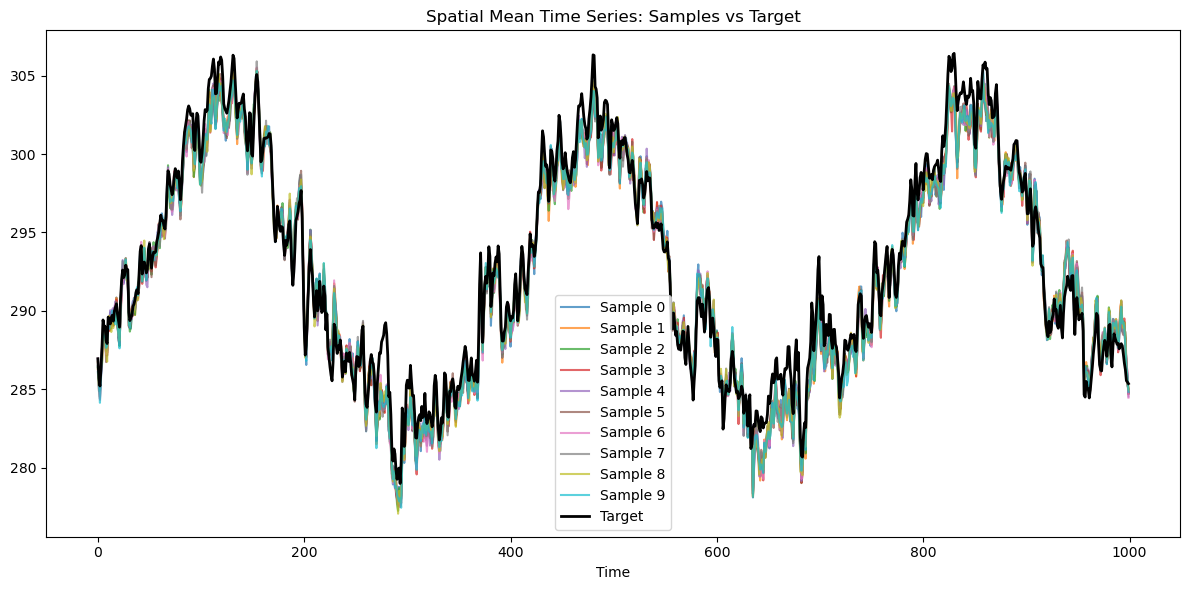

In [205]:
# Calculate spatial mean across y and x dimensions for samples and target
samples = samples_raw.squeeze(1)

samples_mean = samples.mean(dim=(1, 2)) if hasattr(samples, 'mean') else samples[:, :, :, :, 0].cpu().numpy().reshape(samples.shape[0], samples.shape[1], -1).mean(axis=2)
target_mean = target_coarse_raw.mean(dim=(1,2))

# Convert to numpy if needed
if hasattr(samples_mean, 'numpy'):
    samples_mean = samples_mean.numpy()
else:
    samples_mean = samples_mean.cpu().numpy() if hasattr(samples_mean, 'cpu') else samples_mean

# Plot time series
plt.figure(figsize=(12, 6))
for i in range(samples.shape[-1]):
    plt.plot(samples_mean[-1000:, ...,i], label=f'Sample {i}', alpha=0.7)
plt.plot(target_mean[-1000:], label='Target', linewidth=2, color='black')
plt.xlabel('Time')
plt.title('Spatial Mean Time Series: Samples vs Target')
plt.legend()
plt.tight_layout()
plt.show()

### Option 2: creative unnormalise

In [206]:
# Case 1: apply to all data (test + train); not suffled; normalised as in args

test_loader_in, _ = get_data_cordexbench(
            domain=args.domain,
            training_experiment=args.training_experiment,
            shuffle=False, batch_size=512,
            tr_te_split = "random", test_size=0.0,
            server=args.server,
            variables=args.variables, variables_lr=args.variables_lr,
            mode = "train",
            norm_input=args.norm_method_input, norm_output=args.norm_method_output,
            sqrt_transform_in=args.sqrt_transform_in, sqrt_transform_out=args.sqrt_transform_out,
            kernel_size=args.kernel_size_lr, kernel_size_hr=1, return_timepair=False,
            clip_quantile=None, 
            logit=args.logit_transform,
            normal=args.normal_transform,
            include_year=False,
            only_winter=False, stride_lr=None, padding_lr=None,
            filter_outliers=False, precip_zeros="random",
            period_norm="2080-2099",)



/r/scratch/users/mschillinger/data/cordexbench/ALPS/ALPS_domain/train/Emulator_hist_future/target/pr_tasmax_CNRM-CM5_1961-1980_2080-2099.nc
y data: torch.Size([14610, 1, 16384])
x data: torch.Size([14610, 3845])
z (x coarsened) data: torch.Size([14610, 1, 64])


In [207]:
args.norm_method_input, args.norm_method_output

('normalise_per_period', 'normalise_per_period')

In [208]:
model.eval()
preds = []
trues = []
with torch.no_grad():
    for batch in test_loader_in:
        x, xc, y = batch
        x = x.to(device)
        xc = xc.to(device) if xc is not None else None
        y = y.to(device)

        y_hat = model.sample(x.view(x.shape[0], -1), sample_size=10)

        preds.append(y_hat.cpu())
        trues.append(xc.cpu())

samples_norm = torch.cat(preds, dim=0).unsqueeze(1)
trues_tensor = torch.cat(trues, dim=0)

In [209]:
name = "future-estimated"
root="/r/scratch/users/mschillinger/data/cordexbench"

domain=args.domain
training_experiment=args.training_experiment
gcm_name="CNRM-CM5"
if training_experiment == 'ESD_pseudo_reality':
    period_training = '1961-1980'
elif training_experiment == 'Emulator_hist_future':
    period_training = '1961-1980_2080-2099'
data_type=args.variables[0]
name_str = ""
ns_path = os.path.join(root, domain, "norm_stats",
                        f"hr_norm_stats_full-data_{name}_{training_experiment}_{data_type}_{gcm_name}_{period_training}{name_str}.pt")
norm_stats = torch.load(ns_path,  weights_only=False)

In [210]:
norm_stats

{'mean': np.float32(291.75073), 'std': tensor(8.5765)}

In [211]:
samples_raw = []
samples_counterfact_raw = []
batch_size_unnorm = 10000
n_batches = np.ceil(samples_norm.shape[0] / batch_size_unnorm)
for i in range(int(n_batches)):
    gen = samples_norm[i * batch_size_unnorm: (i+1) * batch_size_unnorm]
    
    gen_raw_allvars_list = []
    for i in range(len(args.variables)):
        gen_raw_var_list = []
        
        for j in range(gen.shape[-1]):
            gen_raw = unnormalise(gen[:, i, :, j], mode="hr_avg", data_type=args.variables[i], sqrt_transform=args.sqrt_transform_out, 
                                norm_method=args.norm_method_output, norm_stats=norm_stats)
            gen_raw_var_list.append(gen_raw)
            
        gen_raw_var = torch.stack(gen_raw_var_list, dim=-1)
        gen_raw_allvars_list.append(gen_raw_var)
        
    gen_raw_allvars = torch.stack(gen_raw_allvars_list, dim=1)
    
    # samples.append(gen_raw_allvars)
    samples_raw.append(gen_raw_allvars)
samples_raw = torch.cat(samples_raw, dim=0)

In [212]:
samples_raw.shape

torch.Size([14610, 1, 8, 8, 10])

In [213]:
DATA_PATH = "/r/scratch/users/mschillinger/data/cordexbench/"
folder = "ALPS/ALPS_domain/train"
training_experiment = "Emulator_hist_future"
gcm_name = "CNRM-CM5"
period_training = "1961-1980_2080-2099"
hr_path = f'{DATA_PATH}/{folder}/{training_experiment}/target/pr_tasmax_{gcm_name}_{period_training}.nc'
hr_path

'/r/scratch/users/mschillinger/data/cordexbench//ALPS/ALPS_domain/train/Emulator_hist_future/target/pr_tasmax_CNRM-CM5_1961-1980_2080-2099.nc'

In [214]:
import xarray as xr
target = xr.open_dataset(hr_path)

In [215]:
import torch
import torch.nn.functional as F

# Pooling params (match data.py)
k = args.kernel_size_lr
stride = args.stride_lr if args.stride_lr is not None else k
padding = args.padding_lr if args.padding_lr is not None else 0

vars_hr = args.variables if isinstance(args.variables, (list, tuple)) else [args.variables]
coarse_list = []
for v in vars_hr:
    t = torch.from_numpy(target[v].values).float()   # (time, lat, lon)
    t = torch.flip(t, [1])                           # flip N–S to match training
    n, h, w = t.shape
    pooled = F.avg_pool2d(t.view(n, 1, h, w), kernel_size=k, stride=stride, padding=padding)
    coarse_list.append(pooled.view(n, -1))           # flatten spatial grid

# (time, n_vars, coarse_spatial)
target_coarse_raw = torch.stack(coarse_list, dim=1)
print("coarse target shape:", target_coarse_raw.shape)

coarse target shape: torch.Size([14610, 1, 64])


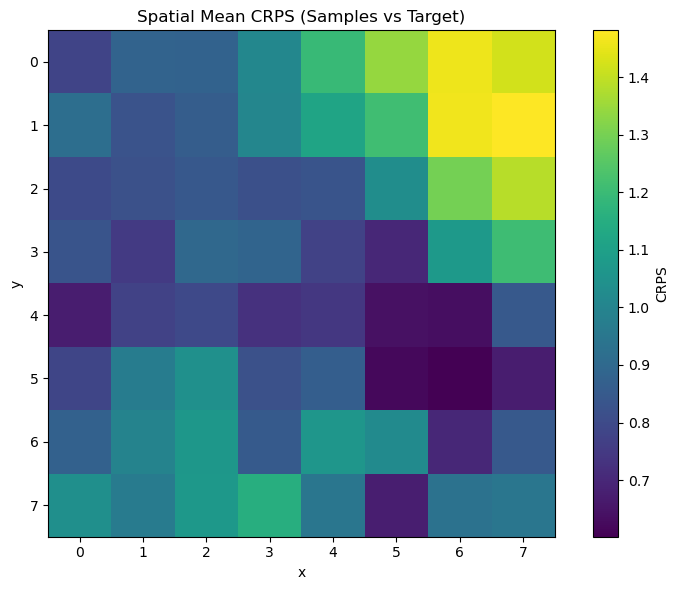

Spatial mean CRPS: 0.94026923


In [216]:
from properscoring import crps_ensemble
samples_np = samples_raw.squeeze(1).numpy()
mid = samples_np.shape[0] // 2
# Get samples: (time, ensemble, y, x)
samples_np_subset = samples_np[mid:]  # (time, y, x, ensemble)
target_np = target_coarse_raw.view(target_coarse_raw.shape[0], 8, 8).numpy()
target_np_subset = target_np[mid:] # (time, y, x)

# Compute CRPS for each grid point and time
crps_map = crps_ensemble(target_np_subset, samples_np_subset)  # shape: (time, y, x)

# Average over time to get spatial CRPS map
crps_spatial = crps_map.mean(axis=0)  # shape: (y, x)

# Plot CRPS map
plt.figure(figsize=(8, 6))
plt.imshow(crps_spatial, cmap='viridis')
plt.colorbar(label='CRPS')
plt.title('Spatial Mean CRPS (Samples vs Target)')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()

# Print spatial mean CRPS (average over all grid points)
print("Spatial mean CRPS:", crps_spatial.mean())

In [217]:
from properscoring import crps_ensemble
samples_np = samples_raw.squeeze(1).numpy()


# Get samples: (time, ensemble, y, x)
samples_np_subset = samples_np.mean(axis=(1,2))
target_np = target_coarse_raw.view(target_coarse_raw.shape[0], 8, 8).numpy()
target_np_subset = target_np.mean(axis=(1,2))

# Compute CRPS for time point
crps_time = crps_ensemble(target_np_subset, samples_np_subset)  

# Print spatial mean CRPS (average over all grid points)
print("Spatial mean CRPS:", crps_time.mean())

Spatial mean CRPS: 0.47035208


In [218]:
from properscoring import crps_ensemble
samples_np = samples_raw.squeeze(1).numpy()


# Get samples: (time, ensemble, y, x)
samples_np_subset = samples_np.mean(axis=(1,2))
target_np = target_coarse_raw.view(target_coarse_raw.shape[0], 8, 8).numpy()
target_np_subset = target_np.mean(axis=(1,2))

# Compute CRPS separately for first and second half
mid = target_np_subset.shape[0] // 2

crps_first = crps_ensemble(target_np_subset[:mid], samples_np_subset[:mid])
crps_second = crps_ensemble(target_np_subset[mid:], samples_np_subset[mid:])

print("Spatial mean (first half):", crps_first.mean())
print("Spatial mean (second half):", crps_second.mean())

Spatial mean (first half): 0.49841258
Spatial mean (second half): 0.4422916


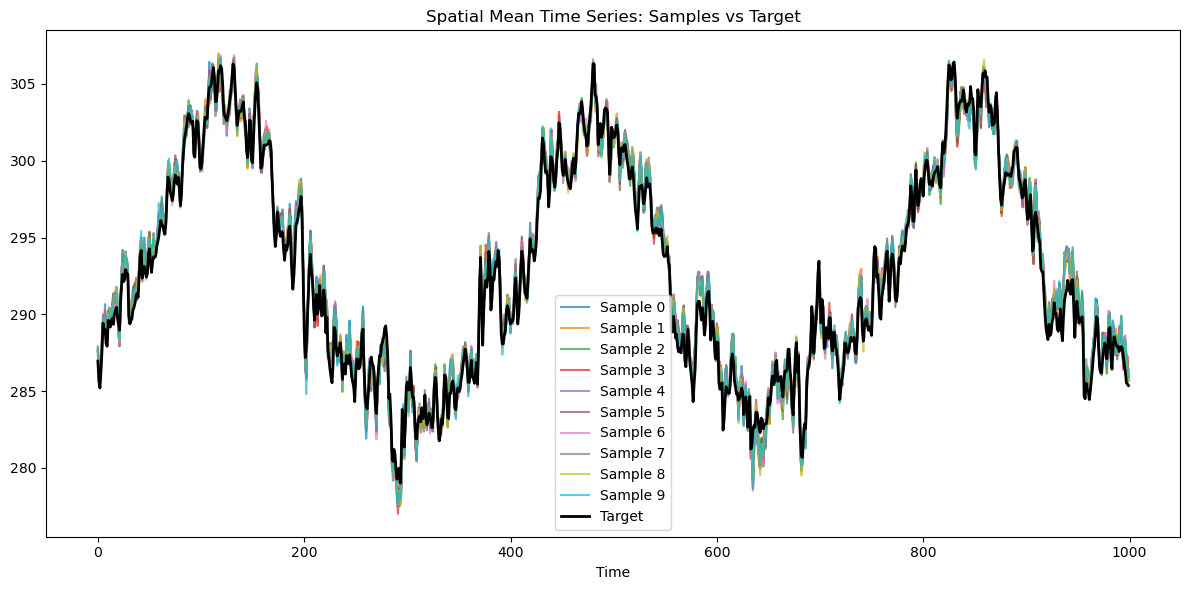

In [219]:
# Calculate spatial mean across y and x dimensions for samples and target
samples = samples_raw.squeeze(1)

samples_mean = samples.mean(dim=(1, 2)) if hasattr(samples, 'mean') else samples[:, :, :, :, 0].cpu().numpy().reshape(samples.shape[0], samples.shape[1], -1).mean(axis=2)
target_mean = target_coarse_raw.mean(dim=(1,2))

# Convert to numpy if needed
if hasattr(samples_mean, 'numpy'):
    samples_mean = samples_mean.numpy()
else:
    samples_mean = samples_mean.cpu().numpy() if hasattr(samples_mean, 'cpu') else samples_mean

# Plot time series
plt.figure(figsize=(12, 6))
for i in range(samples.shape[-1]):
    plt.plot(samples_mean[-1000:, ...,i], label=f'Sample {i}', alpha=0.7)
plt.plot(target_mean[-1000:], label='Target', linewidth=2, color='black')
plt.xlabel('Time')
plt.title('Spatial Mean Time Series: Samples vs Target')
plt.legend()
plt.tight_layout()
plt.show()

## Check assumption with model trained on both past and future

In [3]:
folder = "/r/scratch/users/mschillinger/code/cordexbench/enscale/results/Emulator_hist_future/ALPS/no-orog/coarse/var-tasmax/hd-100_num-lay-6_norm-out-normalise_per_period_norm-in-normalise_per_period_nd-100"
cfg_path =  folder + "/config.txt"
args = read_config(cfg_path)

# quick sanity-check
print("domain:", args.domain)
print("variables:", args.variables)
print("run_indices:", args.run_indices)

domain: ALPS
variables: ['tasmax']
run_indices: [0, 1, 2, 3, 4, 5, 6, 7]


In [4]:
train_loader, test_loader_in = get_data_cordexbench(
        domain=args.domain,
        training_experiment=args.training_experiment,
        shuffle=True, batch_size=512,
        tr_te_split = args.tr_te_split, test_size=1-args.tr_te_split_ratio,
        server=args.server,
        variables=args.variables, variables_lr=args.variables_lr,
        mode = "train",
        norm_input=args.norm_method_input, norm_output=args.norm_method_output,
        sqrt_transform_in=args.sqrt_transform_in, sqrt_transform_out=args.sqrt_transform_out,
        kernel_size=args.kernel_size_lr, kernel_size_hr=args.kernel_size_hr, return_timepair=False,
        clip_quantile=None, 
        logit=args.logit_transform,
        normal=args.normal_transform,
        include_year=False,
        only_winter=False, stride_lr=None, padding_lr=None,
        filter_outliers=False, precip_zeros="random",)

device = "cpu"
x_tr_eval, xc_tr_eval, y_tr_eval = next(iter(train_loader))
x_tr_eval, xc_tr_eval, y_tr_eval = x_tr_eval[:args.n_visual].to(device), xc_tr_eval[:args.n_visual].to(device), y_tr_eval[:args.n_visual].to(device)
x_te_eval, xc_te_eval, y_te_eval = next(iter(test_loader_in))
x_te_eval, xc_te_eval, y_te_eval = x_te_eval[:args.n_visual].to(device), xc_te_eval[:args.n_visual].to(device), y_te_eval[:args.n_visual].to(device)


/r/scratch/users/mschillinger/data/cordexbench/ALPS/ALPS_domain/train/Emulator_hist_future/target/pr_tasmax_CNRM-CM5_1961-1980_2080-2099.nc
y data: torch.Size([14610, 1, 16384])
x data: torch.Size([14610, 3845])
z (x coarsened) data: torch.Size([14610, 1, 64])


In [5]:
if args.variables_lr == ["all"]:
    input_dims_for_preproc = np.array([256 for k in range(15)] +
                [5])
else:
    input_dims_for_preproc = np.array([256 for k in range(len(args.variables_lr))] +
                [5])

In [6]:
in_dim = x_tr_eval.shape[1]
out_dim = y_tr_eval.shape[-1]
interm_dim = xc_tr_eval.shape[-1] * len(args.variables)
if args.method == "eng_temporal":
    in_dim = in_dim + interm_dim
val_dim = None

model = StoUNet(in_dim, interm_dim, args.num_layer, args.hidden_dim, args.noise_dim,
                        add_bn=args.bn, out_act=args.out_act, resblock=args.mlp, noise_std=args.noise_std,
                        preproc_layer=args.preproc_layer,
                        input_dims_for_preproc=input_dims_for_preproc,
                        preproc_dim=args.preproc_dim, layer_shrinkage=args.layer_shrinkage,
                        bottleneck_dim=args.bottleneck_dim).to(device)

In [8]:
model.load_state_dict(torch.load(folder + "/model_199.pt", map_location=device))

<All keys matched successfully>

### Case 1: Past normalisation
Apply model to data normalised for past and also add past spatial mean

In [9]:
# Case 1: apply to all data (test + train); not suffled; normalised as in args

test_loader_in, _ = get_data_cordexbench(
            domain=args.domain,
            training_experiment=args.training_experiment,
            shuffle=False, batch_size=512,
            tr_te_split = "random", test_size=0.0,
            server=args.server,
            variables=args.variables, variables_lr=args.variables_lr,
            mode = "train",
            norm_input=args.norm_method_input, norm_output=args.norm_method_output,
            sqrt_transform_in=args.sqrt_transform_in, sqrt_transform_out=args.sqrt_transform_out,
            kernel_size=args.kernel_size_lr, kernel_size_hr=1, return_timepair=False,
            clip_quantile=None, 
            logit=args.logit_transform,
            normal=args.normal_transform,
            include_year=False,
            only_winter=False, stride_lr=None, padding_lr=None,
            filter_outliers=False, precip_zeros="random",)



/r/scratch/users/mschillinger/data/cordexbench/ALPS/ALPS_domain/train/Emulator_hist_future/target/pr_tasmax_CNRM-CM5_1961-1980_2080-2099.nc
y data: torch.Size([14610, 1, 16384])
x data: torch.Size([14610, 3845])
z (x coarsened) data: torch.Size([14610, 1, 64])


In [10]:
args.norm_method_input, args.norm_method_output

('normalise_per_period', 'normalise_per_period')

In [11]:
model.eval()
preds = []
trues = []
with torch.no_grad():
    for batch in test_loader_in:
        x, xc, y = batch
        x = x.to(device)
        xc = xc.to(device) if xc is not None else None
        y = y.to(device)

        y_hat = model.sample(x.view(x.shape[0], -1), sample_size=10)

        preds.append(y_hat.cpu())
        trues.append(xc.cpu())

samples_norm = torch.cat(preds, dim=0).unsqueeze(1)
trues_tensor = torch.cat(trues, dim=0)

In [13]:
name = "past"
root="/r/scratch/users/mschillinger/data/cordexbench"

domain=args.domain
training_experiment=args.training_experiment
gcm_name="CNRM-CM5"
if training_experiment == 'ESD_pseudo_reality':
    period_training = '1961-1980'
elif training_experiment == 'Emulator_hist_future':
    period_training = '1961-1980_2080-2099'
data_type=args.variables[0]
name_str = ""
ns_path = os.path.join(root, domain, "norm_stats",
                        f"hr_norm_stats_full-data_{name}_{training_experiment}_{data_type}_{gcm_name}_{period_training}{name_str}.pt")
norm_stats = torch.load(ns_path)

In [15]:
samples_raw = []
samples_counterfact_raw = []
batch_size_unnorm = 10000
n_batches = np.ceil(samples_norm.shape[0] / batch_size_unnorm)
for i in range(int(n_batches)):
    gen = samples_norm[i * batch_size_unnorm: (i+1) * batch_size_unnorm]
    
    gen_raw_allvars_list = []
    for i in range(len(args.variables)):
        gen_raw_var_list = []
        
        for j in range(gen.shape[-1]):
            gen_raw = unnormalise(gen[:, i, :, j], mode="hr_avg", data_type=args.variables[i], sqrt_transform=args.sqrt_transform_out, 
                                norm_method=args.norm_method_output, norm_stats=norm_stats)
            gen_raw_var_list.append(gen_raw)
            
        gen_raw_var = torch.stack(gen_raw_var_list, dim=-1)
        gen_raw_allvars_list.append(gen_raw_var)
        
    gen_raw_allvars = torch.stack(gen_raw_allvars_list, dim=1)
    
    # samples.append(gen_raw_allvars)
    samples_raw.append(gen_raw_allvars)
samples_raw = torch.cat(samples_raw, dim=0)

samples_raw_pastnorm = samples_raw.clone()

### Case 2: Future normalisation
Apply model to data normalised for future and also add future spatial mean

In [16]:
# Case 1: apply to all data (test + train); not suffled; normalised as in args

test_loader_in, _ = get_data_cordexbench(
            domain=args.domain,
            training_experiment=args.training_experiment,
            shuffle=False, batch_size=512,
            tr_te_split = "random", test_size=0.0,
            server=args.server,
            variables=args.variables, variables_lr=args.variables_lr,
            mode = "train",
            norm_input=args.norm_method_input, norm_output=args.norm_method_output,
            sqrt_transform_in=args.sqrt_transform_in, sqrt_transform_out=args.sqrt_transform_out,
            kernel_size=args.kernel_size_lr, kernel_size_hr=1, return_timepair=False,
            clip_quantile=None, 
            logit=args.logit_transform,
            normal=args.normal_transform,
            include_year=False,
            only_winter=False, stride_lr=None, padding_lr=None,
            filter_outliers=False, precip_zeros="random",
            period_norm="2080-2099",)



/r/scratch/users/mschillinger/data/cordexbench/ALPS/ALPS_domain/train/Emulator_hist_future/target/pr_tasmax_CNRM-CM5_1961-1980_2080-2099.nc
y data: torch.Size([14610, 1, 16384])
x data: torch.Size([14610, 3845])
z (x coarsened) data: torch.Size([14610, 1, 64])


In [17]:
model.eval()
preds = []
trues = []
with torch.no_grad():
    for batch in test_loader_in:
        x, xc, y = batch
        x = x.to(device)
        xc = xc.to(device) if xc is not None else None
        y = y.to(device)

        y_hat = model.sample(x.view(x.shape[0], -1), sample_size=10)

        preds.append(y_hat.cpu())
        trues.append(xc.cpu())

samples_norm = torch.cat(preds, dim=0).unsqueeze(1)
trues_tensor = torch.cat(trues, dim=0)

In [18]:
name = "future-estimated"
root="/r/scratch/users/mschillinger/data/cordexbench"

domain=args.domain
training_experiment=args.training_experiment
gcm_name="CNRM-CM5"
if training_experiment == 'ESD_pseudo_reality':
    period_training = '1961-1980'
elif training_experiment == 'Emulator_hist_future':
    period_training = '1961-1980_2080-2099'
data_type=args.variables[0]
name_str = ""
ns_path = os.path.join(root, domain, "norm_stats",
                        f"hr_norm_stats_full-data_{name}_{training_experiment}_{data_type}_{gcm_name}_{period_training}{name_str}.pt")
norm_stats = torch.load(ns_path,  weights_only=False)

In [21]:
samples_raw = []
samples_counterfact_raw = []
batch_size_unnorm = 10000
n_batches = np.ceil(samples_norm.shape[0] / batch_size_unnorm)
for i in range(int(n_batches)):
    gen = samples_norm[i * batch_size_unnorm: (i+1) * batch_size_unnorm]
    
    gen_raw_allvars_list = []
    for i in range(len(args.variables)):
        gen_raw_var_list = []
        
        for j in range(gen.shape[-1]):
            gen_raw = unnormalise(gen[:, i, :, j], mode="hr_avg", data_type=args.variables[i], sqrt_transform=args.sqrt_transform_out, 
                                norm_method=args.norm_method_output, norm_stats=norm_stats)
            gen_raw_var_list.append(gen_raw)
            
        gen_raw_var = torch.stack(gen_raw_var_list, dim=-1)
        gen_raw_allvars_list.append(gen_raw_var)
        
    gen_raw_allvars = torch.stack(gen_raw_allvars_list, dim=1)
    
    # samples.append(gen_raw_allvars)
    samples_raw.append(gen_raw_allvars)
samples_raw = torch.cat(samples_raw, dim=0)

samples_raw_futurenorm = samples_raw.clone()

In [22]:
samples_raw_pastnorm.shape, samples_raw_futurenorm.shape

(torch.Size([14610, 1, 8, 8, 10]), torch.Size([14610, 1, 8, 8, 10]))

### Comparison

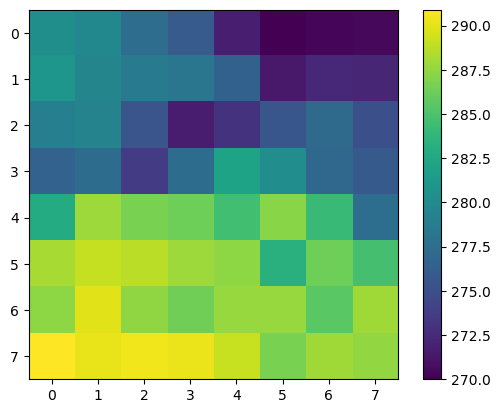

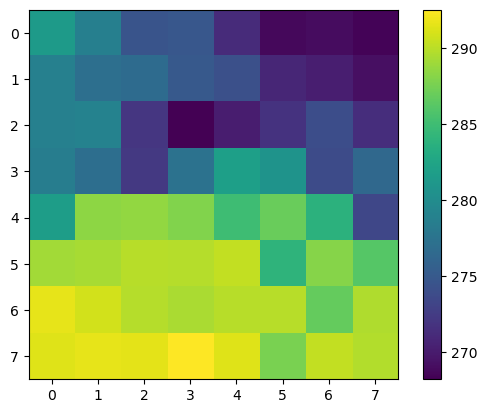

In [25]:
plt.imshow(samples_raw_pastnorm[0, 0, ..., 0].numpy());
plt.colorbar();
plt.show()
plt.imshow(samples_raw_futurenorm[0,0, ..., 0].numpy())
plt.colorbar() 

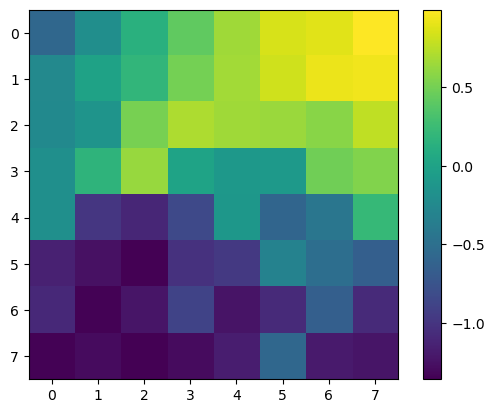

In [27]:
plt.imshow(samples_raw_pastnorm.mean(dim=(0,1,-1)).numpy() - samples_raw_futurenorm.mean(dim=(0,1,-1)).numpy());
plt.colorbar();

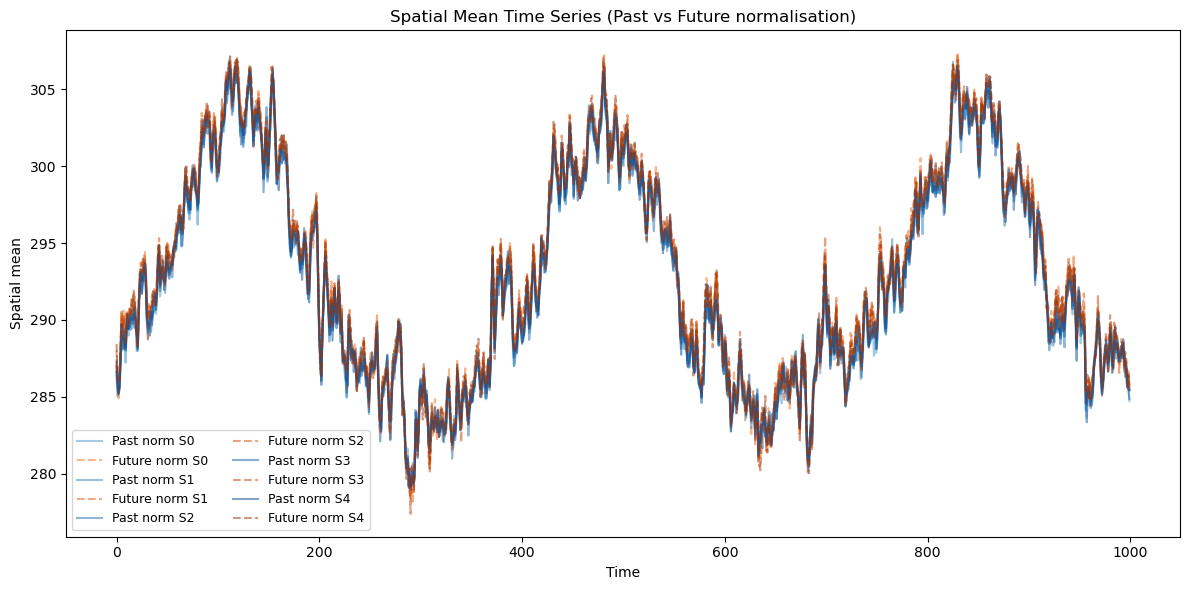

In [31]:
# Visualise spatial mean of a few ensemble samples for past vs future normalisation

def _spatial_mean_samples(samples_raw):
    # samples_raw: (T, V, S, E) or (T, S, E)
    if samples_raw.dim() == 5:
        x = samples_raw.squeeze(1) if samples_raw.size(1) == 1 else samples_raw[:, 0]  # use first variable
        mean = x.mean(dim=(1,2))  # over spatial grid
    elif samples_raw.dim() == 4:
        x = samples_raw.squeeze(1) if samples_raw.size(1) == 1 else samples_raw[:, 0]  # use first variable
        mean = x.mean(dim=(1,2))  # over spatial grid
    elif samples_raw.dim() == 3:
        mean = samples_raw.mean(dim=(1,2))
    else:
        raise ValueError(f"Unexpected shape: {samples_raw.shape}")
    return mean

past_mean = _spatial_mean_samples(samples_raw_pastnorm).cpu().numpy()   # (T, E)
future_mean = _spatial_mean_samples(samples_raw_futurenorm).cpu().numpy()

T = min(past_mean.shape[0], future_mean.shape[0])
last_n = min(1000, T)
n_plot = min(5, past_mean.shape[1], future_mean.shape[1])  # plot up to 5 ensembles
# Set color cycle: past samples in blue shades, future samples in orange shades
past_colors = plt.cm.Blues(np.linspace(0.6, 0.9, n_plot))
future_colors = plt.cm.Oranges(np.linspace(0.6, 0.9, n_plot))
paired_colors = [c for i in range(n_plot) for c in (past_colors[i], future_colors[i])]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=paired_colors)
plt.figure(figsize=(12, 6))
for i in range(n_plot):
    plt.plot(past_mean[T - last_n:, i], label=f'Past norm S{i}', alpha=0.5, linewidth=1.5)
    plt.plot(future_mean[T - last_n:, i], label=f'Future norm S{i}', alpha=0.5, linewidth=1.5, linestyle='--')

plt.xlabel('Time')
plt.ylabel('Spatial mean')
plt.title('Spatial Mean Time Series (Past vs Future normalisation)')
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()

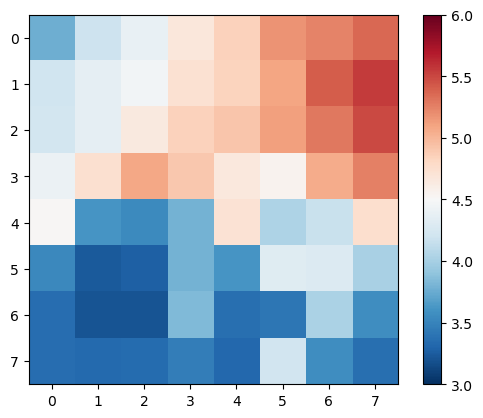

In [40]:
mid = len(samples_raw_pastnorm) // 2
plt.imshow(samples_raw_pastnorm[mid:, 0].mean(axis=(0, -1)) - samples_raw_pastnorm[:mid, 0].mean(axis=(0, -1)), cmap="RdBu_r", vmin = 3, vmax=6);
plt.colorbar()

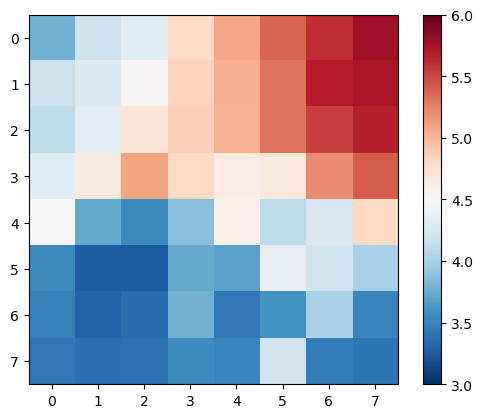

In [41]:
mid = len(samples_raw_futurenorm) // 2
plt.imshow(samples_raw_futurenorm[mid:, 0].mean(axis=(0, -1)) - samples_raw_futurenorm[:mid, 0].mean(axis=(0, -1)), cmap="RdBu_r", vmin = 3, vmax=6);
plt.colorbar()

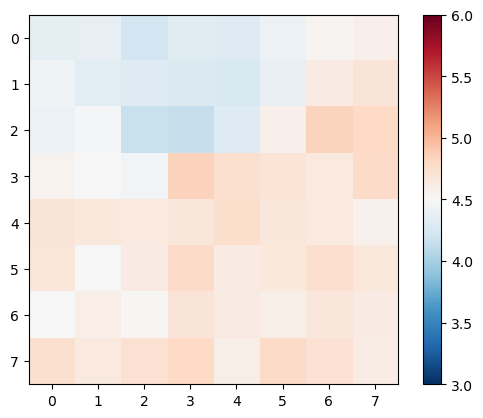

In [42]:
mid = len(samples_raw_futurenorm) // 2
plt.imshow(samples_raw_futurenorm[mid:, 0].mean(axis=(0, -1)) - samples_raw_pastnorm[:mid, 0].mean(axis=(0, -1)), cmap="RdBu_r", vmin = 3, vmax=6);
plt.colorbar()

## Predicting residuals

In [3]:
folder = "/r/scratch/users/mschillinger/code/cordexbench/enscale/results/Emulator_hist_future/ALPS/no-orog/coarse/var-tasmax/hd-100_num-lay-6_norm-out-subtract_linear_norm-in-normalise_scalar_nd-100"
cfg_path =  folder + "/config.txt"
args = read_config(cfg_path)

# quick sanity-check
print("domain:", args.domain)
print("variables:", args.variables)
print("run_indices:", args.run_indices)

domain: ALPS
variables: ['tasmax']
run_indices: [0, 1, 2, 3, 4, 5, 6, 7]


In [4]:
train_loader, test_loader_in = get_data_cordexbench(
        domain=args.domain,
        training_experiment=args.training_experiment,
        shuffle=True, batch_size=512,
        tr_te_split = args.tr_te_split, test_size=1-args.tr_te_split_ratio,
        server=args.server,
        variables=args.variables, variables_lr=args.variables_lr,
        mode = "train",
        norm_input=args.norm_method_input, norm_output=args.norm_method_output,
        sqrt_transform_in=args.sqrt_transform_in, sqrt_transform_out=args.sqrt_transform_out,
        kernel_size=args.kernel_size_lr, kernel_size_hr=args.kernel_size_hr, return_timepair=False,
        clip_quantile=None, 
        logit=args.logit_transform,
        normal=args.normal_transform,
        include_year=False,
        only_winter=False, stride_lr=None, padding_lr=None,
        filter_outliers=False, precip_zeros="random",)

device = "cpu"
x_tr_eval, xc_tr_eval, y_tr_eval = next(iter(train_loader))
x_tr_eval, xc_tr_eval, y_tr_eval = x_tr_eval[:args.n_visual].to(device), xc_tr_eval[:args.n_visual].to(device), y_tr_eval[:args.n_visual].to(device)
x_te_eval, xc_te_eval, y_te_eval = next(iter(test_loader_in))
x_te_eval, xc_te_eval, y_te_eval = x_te_eval[:args.n_visual].to(device), xc_te_eval[:args.n_visual].to(device), y_te_eval[:args.n_visual].to(device)


/r/scratch/users/mschillinger/data/cordexbench/ALPS/ALPS_domain/train/Emulator_hist_future/target/pr_tasmax_CNRM-CM5_1961-1980_2080-2099.nc
y data: torch.Size([14610, 1, 16384])
x data: torch.Size([14610, 3845])
z (x coarsened) data: torch.Size([14610, 1, 64])


In [5]:
if args.variables_lr == ["all"]:
    input_dims_for_preproc = np.array([256 for k in range(15)] +
                [5])
else:
    input_dims_for_preproc = np.array([256 for k in range(len(args.variables_lr))] +
                [5])

In [6]:
in_dim = x_tr_eval.shape[1]
out_dim = y_tr_eval.shape[-1]
interm_dim = xc_tr_eval.shape[-1] * len(args.variables)
if args.method == "eng_temporal":
    in_dim = in_dim + interm_dim
val_dim = None

model = StoUNet(in_dim, interm_dim, args.num_layer, args.hidden_dim, args.noise_dim,
                        add_bn=args.bn, out_act=args.out_act, resblock=args.mlp, noise_std=args.noise_std,
                        preproc_layer=args.preproc_layer,
                        input_dims_for_preproc=input_dims_for_preproc,
                        preproc_dim=args.preproc_dim, layer_shrinkage=args.layer_shrinkage,
                        bottleneck_dim=args.bottleneck_dim).to(device)

In [7]:
model.load_state_dict(torch.load(folder + "/model_999.pt", map_location=device))

<All keys matched successfully>

Note: Unnorm not so easy, because I am on hr_avg scale and haven't saved the preds there. But not needed to understand the residuals

In [29]:
# Case 1: apply to all data (test + train); not suffled; normalised as in args

test_loader_in, _ = get_data_cordexbench(
            domain=args.domain,
            training_experiment=args.training_experiment,
            shuffle=False, batch_size=512,
            tr_te_split = "random", test_size=0.0,
            server=args.server,
            variables=args.variables, variables_lr=args.variables_lr,
            mode = "train",
            norm_input=args.norm_method_input, norm_output=args.norm_method_output,
            sqrt_transform_in=args.sqrt_transform_in, sqrt_transform_out=args.sqrt_transform_out,
            kernel_size=args.kernel_size_lr, kernel_size_hr=1, return_timepair=False,
            clip_quantile=None, 
            logit=args.logit_transform,
            normal=args.normal_transform,
            include_year=False,
            only_winter=False, stride_lr=None, padding_lr=None,
            filter_outliers=False, precip_zeros="random")



/r/scratch/users/mschillinger/data/cordexbench/ALPS/ALPS_domain/train/Emulator_hist_future/target/pr_tasmax_CNRM-CM5_1961-1980_2080-2099.nc
y data: torch.Size([14610, 1, 16384])
x data: torch.Size([14610, 3845])
z (x coarsened) data: torch.Size([14610, 1, 64])


In [33]:
model.eval()
preds = []
trues = []
with torch.no_grad():
    for batch in test_loader_in:
        x, xc, y = batch
        x = x.to(device)
        xc = xc.to(device) if xc is not None else None
        y = y.to(device)

        y_hat = model.sample(x.view(x.shape[0], -1), sample_size=10)

        preds.append(y_hat.cpu())
        trues.append(xc.cpu())

samples_norm = torch.cat(preds, dim=0).unsqueeze(1)
trues_tensor = torch.cat(trues, dim=0)

In [34]:
trues_tensor.shape, samples_norm.shape

(torch.Size([14610, 1, 64]), torch.Size([14610, 1, 64, 10]))

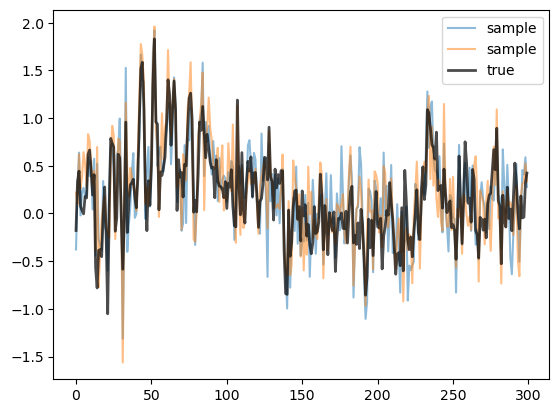

In [35]:
# plot spatial mean time series
samples = samples_norm.squeeze(1)
trues = trues_tensor.squeeze(1)
plt.plot(samples.mean(dim=1).numpy()[:300, 0], alpha=0.5, label = "sample")
plt.plot(samples.mean(dim=1).numpy()[:300, 1], alpha=0.5, label = "sample")
plt.plot(trues.mean(dim=1).numpy()[:300], color='black', linewidth=2, alpha=0.7, label='true')
plt.legend()

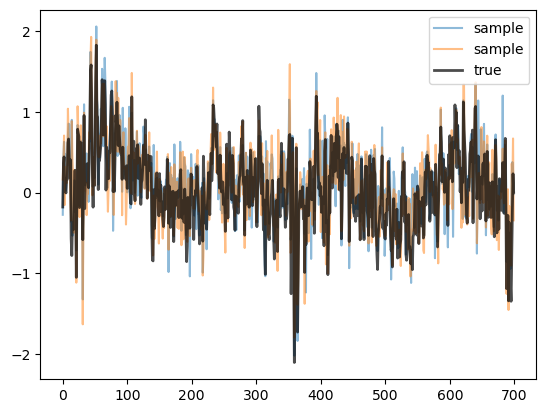

In [74]:
# plot spatial mean time series
samples = samples_norm.squeeze(1)
trues = trues_tensor.squeeze(1)
plt.plot(samples.mean(dim=1).numpy()[:700, 0], alpha=0.5, label = "sample")
plt.plot(samples.mean(dim=1).numpy()[:700, 1], alpha=0.5, label = "sample")
plt.plot(trues.mean(dim=1).numpy()[:700], color='black', linewidth=2, alpha=0.7, label='true')
plt.legend()

In [78]:
DATA_PATH = "/r/scratch/users/mschillinger/data/cordexbench/"
folder = "ALPS/ALPS_domain/train"
training_experiment = "Emulator_hist_future"
gcm_name = "CNRM-CM5"
period_training = "1961-1980_2080-2099"
hr_path = f'{DATA_PATH}/{folder}/{training_experiment}/target/pr_tasmax_{gcm_name}_{period_training}.nc'
hr_path
target = xr.open_dataset(hr_path)

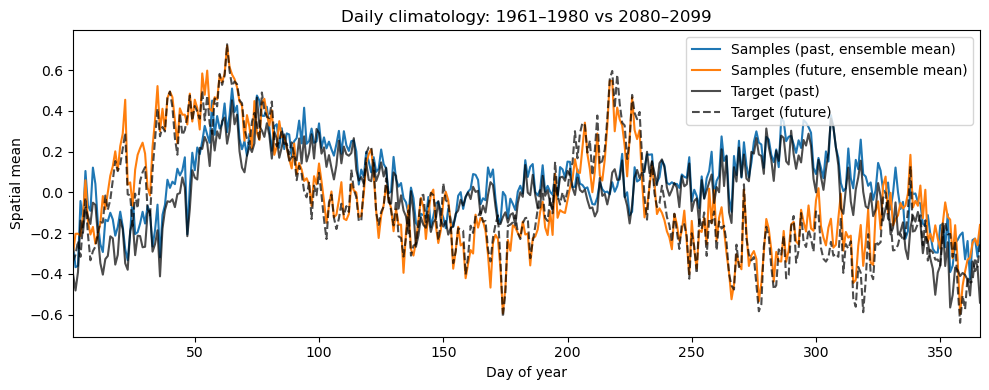

In [79]:
# plot spatial mean time series
# spatial mean over grid
samples = samples_norm.squeeze(1)          # (T, S, E)
trues = trues_tensor.squeeze(1)            # (T, S)
samples_mean = samples.mean(dim=1).cpu().numpy()  # (T, E)
trues_mean = trues.mean(dim=1).cpu().numpy()      # (T,)
# align with xarray time and group by day-of-year; compare past (1961–1980) vs future (2080–2099)
years = target['time'].dt.year.values
doy = target['time'].dt.dayofyear.values

T = min(len(doy), samples_mean.shape[0], trues_mean.shape[0])
years = years[:T]
doy = doy[:T]
samples_mean = samples_mean[:T]
trues_mean = trues_mean[:T]

past_mask = (years >= 1961) & (years <= 1980)
future_mask = (years >= 2080) & (years <= 2099)
doys = np.arange(1, 367)

def mean_by_doy(vals, doy, mask):
    out = []
    for d in doys:
        sel = (doy == d) & mask
        if vals.ndim == 2:
            v = vals[sel].mean(axis=0) if sel.any() else np.full((vals.shape[1],), np.nan)
            v = v.mean()  # ensemble mean
        else:
            v = vals[sel].mean() if sel.any() else np.nan
        out.append(v)
    return np.array(out)

samples_past_doy = mean_by_doy(samples_mean, doy, past_mask)
samples_future_doy = mean_by_doy(samples_mean, doy, future_mask)
trues_past_doy = mean_by_doy(trues_mean, doy, past_mask)
trues_future_doy = mean_by_doy(trues_mean, doy, future_mask)

# plot daily climatology by day-of-year
plt.figure(figsize=(10, 4))
plt.plot(doys, samples_past_doy, label='Samples (past, ensemble mean)')
plt.plot(doys, samples_future_doy, label='Samples (future, ensemble mean)')
plt.plot(doys, trues_past_doy, label='Target (past)', color='black', linewidth=1.5, alpha=0.7)
plt.plot(doys, trues_future_doy, label='Target (future)', color='black', linestyle='--', linewidth=1.5, alpha=0.7)
plt.xlim(1, 366)
plt.xlabel('Day of year')
plt.ylabel('Spatial mean')
plt.title('Daily climatology: 1961–1980 vs 2080–2099')
plt.legend()
plt.tight_layout()

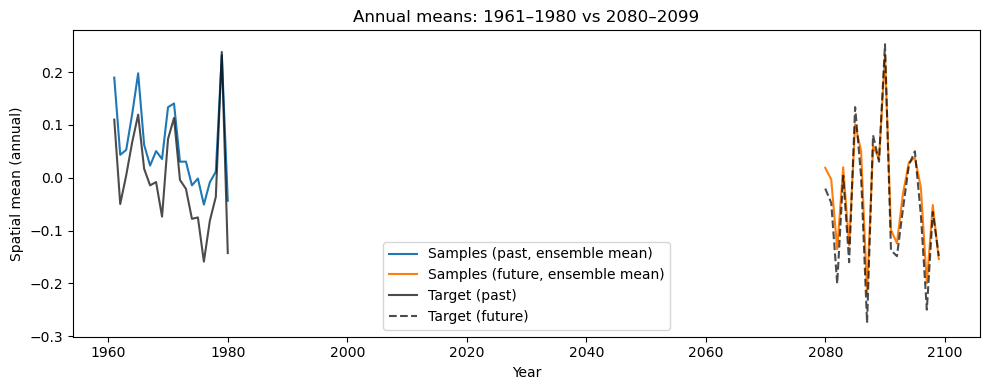

In [83]:
# plot spatial mean time series
# spatial mean over grid
samples = samples_norm.squeeze(1)          # (T, S, E)
trues = trues_tensor.squeeze(1)            # (T, S)
samples_mean = samples.mean(dim=1).cpu().numpy()  # (T, E)
trues_mean = trues.mean(dim=1).cpu().numpy()      # (T,)
# align with xarray time and group by day-of-year; compare past (1961–1980) vs future (2080–2099)
years = target['time'].dt.year.values
doy = target['time'].dt.dayofyear.values

T = min(len(doy), samples_mean.shape[0], trues_mean.shape[0])
years = years[:T]
doy = doy[:T]
samples_mean = samples_mean[:T]
trues_mean = trues_mean[:T]

past_mask = (years >= 1961) & (years <= 1980)
future_mask = (years >= 2080) & (years <= 2099)
doys = np.arange(1, 367)

# annual means (ensemble mean for samples), past vs future
samples_ens = samples_mean.mean(axis=1)  # (T,)
def annual_means(vals, yrs, mask):
    yrs_sel = yrs[mask]
    vals_sel = vals[mask]
    u = np.unique(yrs_sel)
    return u, np.array([vals_sel[yrs_sel == y].mean() for y in u])

years_past, samples_past_ann = annual_means(samples_ens, years, past_mask)
_, trues_past_ann = annual_means(trues_mean, years, past_mask)
years_future, samples_future_ann = annual_means(samples_ens, years, future_mask)
_, trues_future_ann = annual_means(trues_mean, years, future_mask)

plt.figure(figsize=(10, 4))
plt.plot(years_past, samples_past_ann, label='Samples (past, ensemble mean)')
plt.plot(years_future, samples_future_ann, label='Samples (future, ensemble mean)')
plt.plot(years_past, trues_past_ann, label='Target (past)', color='black', linewidth=1.5, alpha=0.7)
plt.plot(years_future, trues_future_ann, label='Target (future)', color='black', linestyle='--', linewidth=1.5, alpha=0.7)
plt.xlabel('Year')
plt.ylabel('Spatial mean (annual)')
plt.title('Annual means: 1961–1980 vs 2080–2099')
plt.legend()
plt.tight_layout()

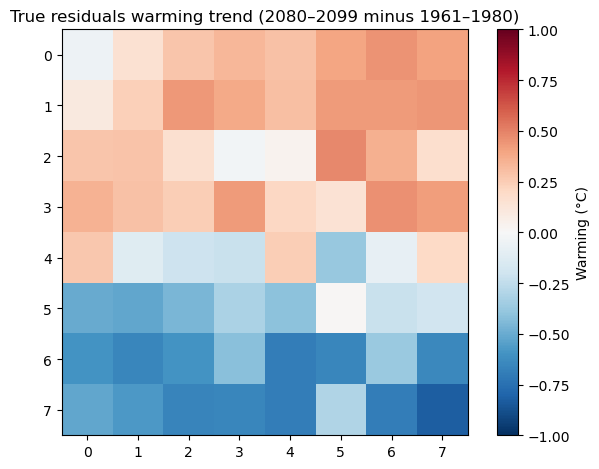

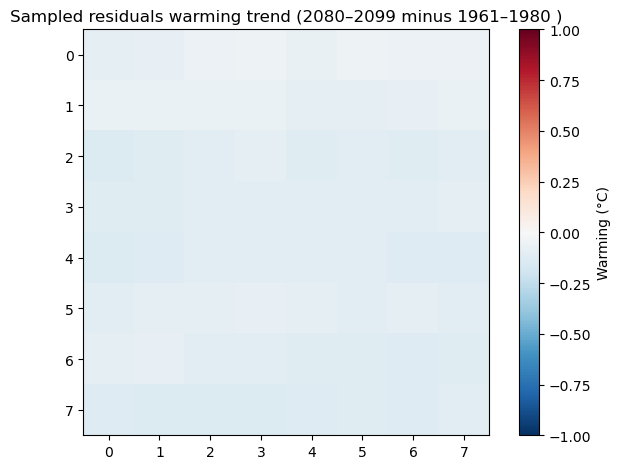

In [82]:
# warming trend, second half minus first half in each gridpoint
mid = len(trues_tensor) // 2
trues_tensor_spatial = trues_tensor[:, 0, ...].view(-1, 8, 8)  # (T, y, x)
samples_spatial = samples_norm[:, 0, ...].view(-1, 8, 8)  # (T, y, x)
trues_trend = trues_tensor_spatial[mid:].mean(dim=0) - trues_tensor_spatial[:mid].mean(dim=0)
samples_trend = samples_spatial[mid:].mean(dim=0) - samples_spatial[:mid].mean(dim=0)
plt.imshow(trues_trend.cpu(), cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar(label='Warming (°C)')
plt.title('True residuals warming trend (2080–2099 minus 1961–1980)')
plt.tight_layout() 
plt.show()
plt.imshow(samples_trend.cpu(), cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar(label='Warming (°C)')
plt.title('Sampled residuals warming trend (2080–2099 minus 1961–1980 )')
plt.tight_layout()
plt.show()

Now test if residuals depend on spatial mean of X

In [44]:
def subtract_spatial_mean_per_variable(X, n_vars=15, extra_dim=5):
    X_onlyvars = X.clone()[..., :-extra_dim]
    dim_per_var = X_onlyvars.shape[-1] // n_vars
    X_reshaped = X_onlyvars.view(*X_onlyvars.shape[:-1], n_vars, dim_per_var)
    spatial_mean = X_reshaped.mean(dim=-1, keepdim=True)
    X_centered = X_reshaped - spatial_mean
    X_centered = X_centered.view(*X_onlyvars.shape[:-1], n_vars * dim_per_var)
    return X_centered

In [51]:
model.eval()
preds = []
trues = []
with torch.no_grad():
    for batch in test_loader_in:
        x, xc, y = batch
        x = x.to(device)
        xc = xc.to(device) if xc is not None else None
        y = y.to(device)
        x_centered = subtract_spatial_mean_per_variable(x, n_vars=15, extra_dim=5)
        x_centered = torch.cat([x_centered, x[..., -5:]], dim=-1)
        y_hat = model.sample(x_centered.view(x_centered.shape[0], -1), sample_size=10)

        preds.append(y_hat.cpu())
        trues.append(xc.cpu())

samples_norm = torch.cat(preds, dim=0).unsqueeze(1)
trues_tensor = torch.cat(trues, dim=0)

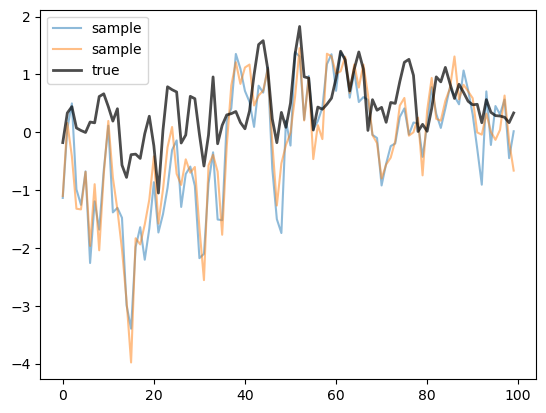

In [52]:
# plot spatial mean time series
samples = samples_norm.squeeze(1)
trues = trues_tensor.squeeze(1)
plt.plot(samples.mean(dim=1).numpy()[:100, 0], alpha=0.5, label = "sample")
plt.plot(samples.mean(dim=1).numpy()[:100, 1], alpha=0.5, label = "sample")
plt.plot(trues.mean(dim=1).numpy()[:100], color='black', linewidth=2, alpha=0.7, label='true')
plt.legend()

Apply to only future data and subtract period mean

In [9]:
# Case 1: apply to all data (test + train); not suffled; normalised as in args

train_loader, test_loader_in = get_data_cordexbench(
            domain=args.domain,
            training_experiment=args.training_experiment,
            shuffle=False, batch_size=512,
            tr_te_split = "past_future", test_size=0.0,
            server=args.server,
            variables=args.variables, variables_lr=args.variables_lr,
            mode = "train",
            norm_input="normalise_per_period", norm_output=args.norm_method_output,
            sqrt_transform_in=args.sqrt_transform_in, sqrt_transform_out=args.sqrt_transform_out,
            kernel_size=args.kernel_size_lr, kernel_size_hr=1, return_timepair=False,
            clip_quantile=None, 
            logit=args.logit_transform,
            normal=args.normal_transform,
            include_year=False,
            only_winter=False, stride_lr=None, padding_lr=None,
            filter_outliers=False, precip_zeros="random",
            period_norm="2080-2099",)

/r/scratch/users/mschillinger/data/cordexbench/ALPS/ALPS_domain/train/Emulator_hist_future/target/pr_tasmax_CNRM-CM5_1961-1980_2080-2099.nc
y data: torch.Size([14610, 1, 16384])
x data: torch.Size([14610, 3845])
z (x coarsened) data: torch.Size([14610, 1, 64])


In [10]:
model.eval()
preds = []
trues = []
with torch.no_grad():
    for batch in test_loader_in:
        x, xc, y = batch
        x = x.to(device)
        xc = xc.to(device) if xc is not None else None
        y = y.to(device)

        y_hat = model.sample(x.view(x.shape[0]), sample_size=10)

        preds.append(y_hat.cpu())
        trues.append(xc.cpu())

samples_norm = torch.cat(preds, dim=0).unsqueeze(1)
trues_tensor = torch.cat(trues, dim=0)

RuntimeError: shape '[512]' is invalid for input of size 1968640

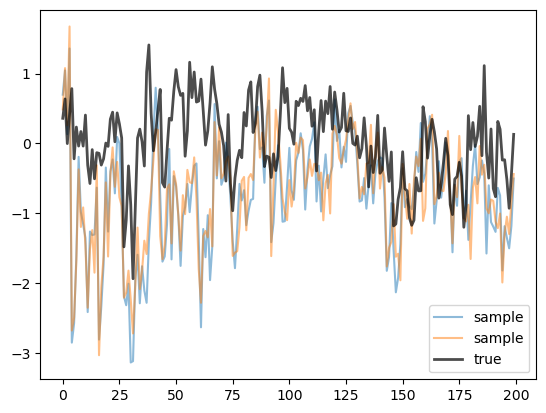

In [ ]:
# plot spatial mean time series
samples = samples_norm.squeeze(1)
trues = trues_tensor.squeeze(1)
plt.plot(samples.mean(dim=1).numpy()[:200, 0], alpha=0.5, label = "sample")
plt.plot(samples.mean(dim=1).numpy()[:200, 1], alpha=0.5, label = "sample")
plt.plot(trues.mean(dim=1).numpy()[:200], color='black', linewidth=2, alpha=0.7, label='true')
plt.legend()

In [ ]:
model.eval()
preds = []
trues = []
with torch.no_grad():
    for batch in train_loader:
        x, xc, y = batch
        x = x.to(device)
        xc = xc.to(device) if xc is not None else None
        y = y.to(device)

        y_hat = model.sample(x.view(x.shape[0], -1), sample_size=10)

        preds.append(y_hat.cpu())
        trues.append(xc.cpu())

samples_norm = torch.cat(preds, dim=0).unsqueeze(1)
trues_tensor = torch.cat(trues, dim=0)

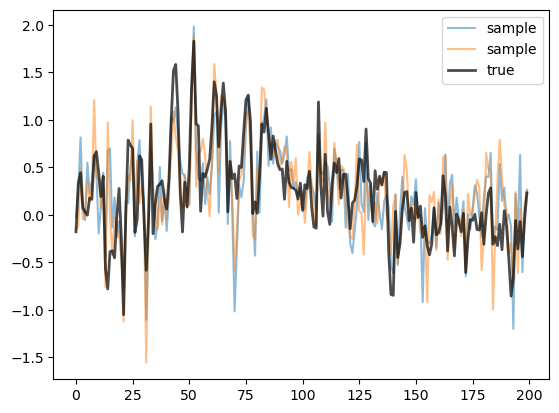

In [ ]:
# plot spatial mean time series
samples = samples_norm.squeeze(1)
trues = trues_tensor.squeeze(1)
plt.plot(samples.mean(dim=1).numpy()[:200, 0], alpha=0.5, label = "sample")
plt.plot(samples.mean(dim=1).numpy()[:200, 1], alpha=0.5, label = "sample")
plt.plot(trues.mean(dim=1).numpy()[:200], color='black', linewidth=2, alpha=0.7, label='true')
plt.legend()

Subtract climate change trend from predictors!

In [16]:
# Case 1: apply to all data (test + train); not suffled; normalised as in args

test_loader_in, _ = get_data_cordexbench(
            domain=args.domain,
            training_experiment=args.training_experiment,
            shuffle=False, batch_size=512,
            tr_te_split = "random", test_size=0.0,
            server=args.server,
            variables=args.variables, variables_lr=args.variables_lr,
            mode = "train",
            norm_input=args.norm_method_input, norm_output=args.norm_method_output,
            sqrt_transform_in=args.sqrt_transform_in, sqrt_transform_out=args.sqrt_transform_out,
            kernel_size=args.kernel_size_lr, kernel_size_hr=1, return_timepair=False,
            clip_quantile=None, 
            logit=args.logit_transform,
            normal=args.normal_transform,
            include_year=False,
            only_winter=False, stride_lr=None, padding_lr=None,
            filter_outliers=False, precip_zeros="random",
            remove_climate_change_trend=True)



/r/scratch/users/mschillinger/data/cordexbench/ALPS/ALPS_domain/train/Emulator_hist_future/target/pr_tasmax_CNRM-CM5_1961-1980_2080-2099.nc
y data: torch.Size([14610, 1, 16384])
x data: torch.Size([14610, 3845])
z (x coarsened) data: torch.Size([14610, 1, 64])


In [17]:
model.eval()
preds = []
trues = []
with torch.no_grad():
    for batch in test_loader_in:
        x, xc, y = batch
        x = x.to(device)
        xc = xc.to(device) if xc is not None else None
        y = y.to(device)

        y_hat = model.sample(x.view(x.shape[0], -1), sample_size=10)

        preds.append(y_hat.cpu())
        trues.append(xc.cpu())

samples_norm = torch.cat(preds, dim=0).unsqueeze(1)
trues_tensor = torch.cat(trues, dim=0)

In [18]:
trues_tensor.shape, samples_norm.shape

(torch.Size([14610, 1, 64]), torch.Size([14610, 1, 64, 10]))

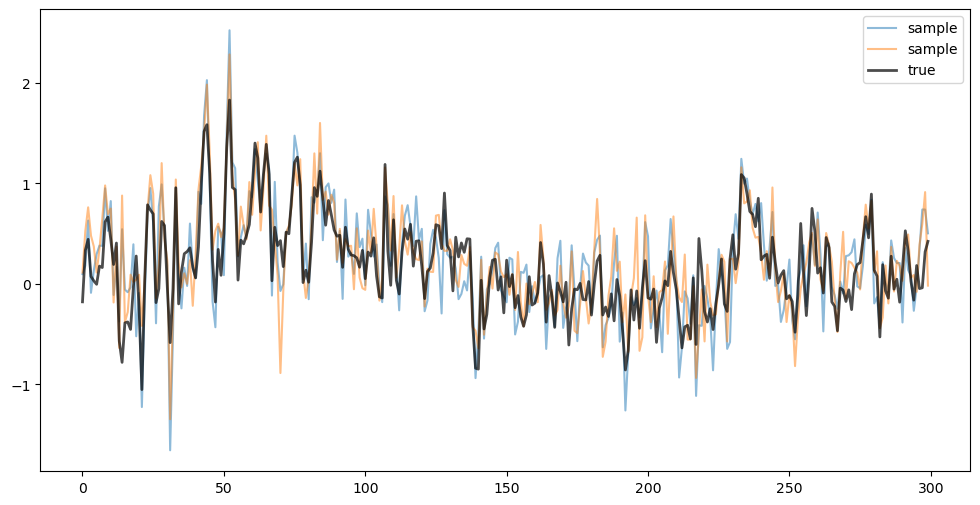

In [19]:
# plot spatial mean time series
samples = samples_norm.squeeze(1)
trues = trues_tensor.squeeze(1)
plt.figure(figsize=(12, 6))
plt.plot(samples.mean(dim=1).numpy()[:300, 0], alpha=0.5, label = "sample")
plt.plot(samples.mean(dim=1).numpy()[:300, 1], alpha=0.5, label = "sample")
plt.plot(trues.mean(dim=1).numpy()[:300], color='black', linewidth=2, alpha=0.7, label='true')
plt.legend()

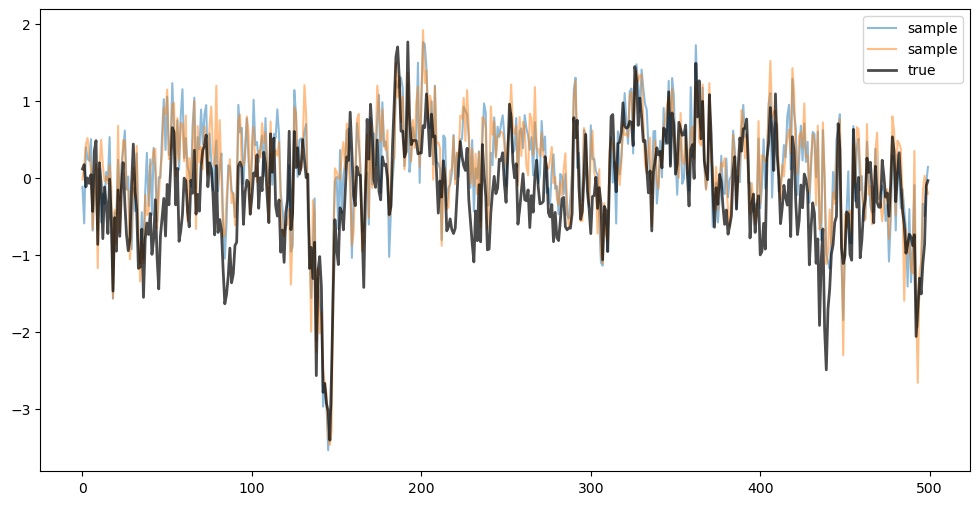

In [20]:
# plot spatial mean time series
samples = samples_norm.squeeze(1)
trues = trues_tensor.squeeze(1)
plt.figure(figsize=(12, 6))
plt.plot(samples.mean(dim=1).numpy()[-500:, 0], alpha=0.5, label = "sample")
plt.plot(samples.mean(dim=1).numpy()[-500:, 1], alpha=0.5, label = "sample")
plt.plot(trues.mean(dim=1).numpy()[-500:], color='black', linewidth=2, alpha=0.7, label='true')
plt.legend()